# Essentials

In [1]:
from google.colab import drive #don't run this cell if you don't use google colab
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#All needed imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
from skimage.filters import sobel
import seaborn as sns
from skimage import feature
#models
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [24]:
#constants
MASK_CC_THRESHOLD=100
LINES_PEAKS_DIVIDER=3
#update these paths to the full paths where you keep the images
PATH_TO_A_D = "/content/drive/MyDrive/Pattern Project/formsA-D/"
PATH_TO_E_H = "/content/drive/MyDrive/Pattern Project/formsE-H/"
PATH_TO_I_Z = "/content/drive/MyDrive/Pattern Project/formsI-Z/"

PATH_TO_AUTHOR = "/content/drive/MyDrive/Pattern Project/file_author.csv"
PATH_TO_DATA ="/content/drive/MyDrive/Pattern Project/converted_dataset/"

# Preproccessing

In [4]:
def preProcessTheImage(image):
    image = cv2.GaussianBlur(image, (5, 5), 0)[:, 150:-50] # Blur the image and crop some white space from both sides to fasten the process 
    thresh, bin_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) #get the binary image
    contours, _ = cv2.findContours(bin_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) #get the contours of the binary image
    height, width = image.shape
    top, bottom, left, right = 0, height - 1, 0, width - 1
    
    countoursBoundingBox = np.asarray([np.asarray(cv2.boundingRect(contour)) for contour in contours])
    countoursBoundingBox = countoursBoundingBox[countoursBoundingBox[:,2] > 1000]
    cutMask = countoursBoundingBox[:,1] < height // 2
    upperHalfCountours = countoursBoundingBox[cutMask]
    lowerHalfCountours = countoursBoundingBox[np.logical_not(cutMask)]
    top = np.max(upperHalfCountours[:,1]+upperHalfCountours[:,3]+10)
    bottom = np.min(lowerHalfCountours[:,1]-10)

    noiselessImage = cv2.erode(bin_img, np.ones((3, 3), np.uint8), iterations=2) #erode the image to get rid of any noise
    horizontalHistogram = np.sum(noiselessImage, axis=1)[top:bottom+1] 
    verticalHistogram = np.sum(noiselessImage, axis=0) 
    left+=(verticalHistogram!=0).argmax()
    right-=(verticalHistogram[::-1]!=0).argmax()
    top+=(horizontalHistogram!=0).argmax()
    bottom-=(horizontalHistogram[::-1]!=0).argmax()
    return image[top:bottom + 1, left:right + 1],bin_img[top:bottom + 1, left:right + 1] #preprocessed image

# Segmentation

In [5]:
def getConnectedComponents(binaryImage): #only returns the centroids, stats, and the visual image of the needed components 
#--------------------------------------------------------------------------------------------------------------------------#
#cv2.CC_STAT_LEFT The leftmost (x) coordinate which is the inclusive start of the bounding box in the horizontal direction.
#cv2.CC_STAT_TOP The topmost (y) coordinate which is the inclusive start of the bounding box in the vertical direction.
#cv2.CC_STAT_WIDTH The horizontal size of the bounding box
#cv2.CC_STAT_HEIGHT The vertical size of the bounding box
#cv2.CC_STAT_AREA The total area (in pixels) of the connected component
#--------------------------------------------------------------------------------------------------------------------------#
  nb_components, cc_output, stats, centroids  = cv2.connectedComponentsWithStats(binaryImage, connectivity=8)
  mask = np.where(stats[:,-1] > MASK_CC_THRESHOLD)[0] #get rid of all the commas and periods. The MASK_CC_THRESHOLD value could be change later on.
  return centroids[mask],stats[mask],cc_output

In [6]:
def visualizeTheConnectedComponentsOfTheImage(cc_output,stats,nb_components):
  fig, ax = plt.subplots(figsize=(20, 20))
  cclabeledImg = cc_output.copy()
  mask = np.where(stats[:,-1] > MASK_CC_THRESHOLD)[0] #get rid of all the commas and periods. The MASK_CC_THRESHOLD value could be change later on.
  cclabeledImg[np.isin( cclabeledImg,mask)] = 0
  value = 0.0
  for label in np.unique(cclabeledImg):
    cclabeledImg[cclabeledImg==label] = cclabeledImg[cclabeledImg==label] + value
    value += (255/nb_components)
  ax.imshow(cclabeledImg)

In [7]:
# Get the horzinotal projection of sobel image
def getHorizontalHist(binaryImage):
  sobelImg = sobel(binaryImage)
  return np.sum(sobelImg,axis=1)

In [8]:
def visualizeHorizontalHist(horizontalHist):
  plt.figure(figsize=(8,5))
  plt.plot(horizontalHist)

In [9]:
#Take the top peaks
def getLinesPeaks(horizontalHist,binaryImage):
  threshold = (np.max(horizontalHist) - np.min(horizontalHist)) / LINES_PEAKS_DIVIDER
  peaks_index = np.where(horizontalHist > threshold)[0]
  linesImage = binaryImage.copy()
  linesImage[peaks_index,:] = 0
  return peaks_index

In [10]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [11]:
def getLinesBoundaries(binaryImage): #to know the limits of each line
  horizontalHist=getHorizontalHist(binaryImage) 
  peaks_index=getLinesPeaks(horizontalHist,binaryImage)
  hpClusters = consecutive(peaks_index)

  threshold = -1
  for i in range(len(hpClusters)):
    value = len(hpClusters[i])
    if threshold < value:
      threshold = value

  threshold /= 2
  minArray = []
  maxArray = []

  for i in range(len(hpClusters)):
    if len(hpClusters[i]) >= threshold:
      minArray.append(hpClusters[i][0])
      maxArray.append(hpClusters[i][-1])

  lines=[0]
  avg = 0
  for i in range(len(maxArray)-1):
    diff = (minArray[i+1] - maxArray[i])/2
    lines.append( int(maxArray[i] + diff))
    avg += diff

  if len(maxArray) > 1:
    lines.append(int(maxArray[-1] + avg/(len(maxArray)-1)))
  else:
    lines.append(int(maxArray[-1] + avg))

  return lines

In [12]:
def visualizeTheSeperatingLines(binaryImage,lines):
  testImage = binaryImage.copy()
  for line in lines:
      cv2.line(testImage, (0,int(line)), (testImage.shape[1]-1,int(line)), 125, 2)

  plt.figure(figsize=(20,20))
  plt.imshow(testImage)

In [13]:
def createTextureImage(greyImage,binaryImage): #coverts the text image to texture
  lines=getLinesBoundaries(binaryImage) #get the seperating lines

  centroids,stats,cc_output =getConnectedComponents(binaryImage) #get the connected components
  textureImage = np.full(binaryImage.shape,255)
  y_current = 0
  currentRange = 0
  y_avg = 0
  y_sum = 0
  y_count = 0

  y_sum_prev=0
  y_count_prev = 0
  y_prev = 0
  
  x_start = stats[1,0]
  x_end = 0
  for i in range(1,len(centroids)):
    
    if currentRange+1 == len(lines):
      break
    if lines[currentRange+1] > centroids[i,1] :
      if not (lines[currentRange] < centroids[i,1]):
          currentRange -= 1
          y_avg = y_sum_prev / y_count_prev
          y_sum = y_sum_prev
          y_count = y_count_prev
    else:
      y_avg = y_sum / y_count
      y_avg_prev = y_avg
      y_prev = y_current
      y_current += int(y_avg/2)
      currentRange += 1
      y_sum_prev=y_sum
      y_count_prev = y_count
      y_sum =0
      y_count =0

      
    if stats[i,0]< x_start:
        x_start = stats[i,0]
    if stats[i-1,0] > x_end:
      x_end = stats[i-1,0] + stats[i-1,2]  
  

    toBeCopied = greyImage[stats[i,1]: stats[i,1] + stats[i,3],stats[i,0] :stats[i,0] + stats[i,2]]
    toBeCopiedMask = toBeCopied <= 200
    textureImage[y_current:y_current+ stats[i,3],stats[i,0] :stats[i,0] + stats[i,2]][toBeCopiedMask] = toBeCopied[toBeCopiedMask]
    y_sum += stats[i,3]
    y_count += 1

  return textureImage[:int(y_current+y_avg*1.5),int(x_start):int(x_end)]

In [14]:
def visualizeTextureImage(textureImage):
  plt.figure(figsize=(20,20))
  plt.imshow(textureImage,cmap='gray')

In [15]:
def divideTextureImageIntoBlocks(textureImage,divide=3): #takes in a numpy textue mage
    h, w = textureImage.shape
    h_new= h - (h % divide)
    w_new= w - (w % divide) 
    textureImage=textureImage[0:h_new, 0:w_new]
    segment1=h_new//divide
    segment2=w_new//divide
    return (textureImage.reshape(h_new//segment1, segment1, -1, segment2)
               .swapaxes(1,2)
               .reshape(-1, segment1, segment2))

In [16]:
def visualizeTextureBlocks(textureBlocks):
  for block in textureBlocks:
    plt.figure(figsize=(5,5))
    plt.imshow(block,cmap='gray')

In [17]:
def convertImagesIntoTextureBlocks(dataset,authorMap,exp_beta=30):
  textureBlocks=[]
  currentPath = ''
  labels = []
  for path,author in dataset.values:
    
    if path[0] <= 'd':
      currentPath = PATH_TO_A_D
    elif path[0] <= 'h':
      currentPath = PATH_TO_E_H
    else:
      currentPath = PATH_TO_I_Z
    greyImage = cv2.imread(currentPath+path,cv2.IMREAD_GRAYSCALE)

    gImg,bImg = preProcessTheImage(greyImage)


    labels+=list(np.repeat(author, 9))
    textureBlocks += list(divideTextureImageIntoBlocks(createTextureImage(gImg,bImg)))
    if np.random.exponential(authorMap[author]/exp_beta) <= 0.5:
      seq = iaa.Sequential([
       iaa.Crop(px=(np.min(gImg.shape)//5, np.min(gImg.shape)//3)), 
      ])
      
      random_gImg = seq(images=gImg)
      if random_gImg.shape[0] < 600:
        continue
      thresh, random_bImg = cv2.threshold(random_gImg, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) #get the binary image
      textureBlocks += list(divideTextureImageIntoBlocks(createTextureImage(random_gImg,random_bImg)))
      labels+=list(np.repeat(author, 9))
      authorMap[author] +=1
  return textureBlocks,labels


# Feature Extraction

In [18]:
def getFeaturesLBP(textureBlock, sampling_pixels=8,radius=3):
    # normalize the values of the grey scale image
    i_min = np.min(textureBlock)
    i_max = np.max(textureBlock)
    if (i_max - i_min != 0):
        textureBlock = (textureBlock - i_min)/(i_max-i_min)
    
    # compute LBP
    lbp = feature.local_binary_pattern(textureBlock, sampling_pixels, radius)
    
    # compute the histogram of the matrix obtained from LBP to get 256 features
    (hist, _) = np.histogram(lbp.ravel(),bins=256)

    # normalization might or might not be required, if it is uncomment these two lines
    hist = hist.astype(np.float)
    #hist /= np.sum(hist)
    return hist

In [19]:
def visualizeFeaturesLBP(blockFeaturesLBP):
  plt.figure(figsize=(20,20))
  res = blockFeaturesLBP
  sns.lineplot(x=range(len(res)),y=blockFeaturesLBP)

In [20]:
def featuresOfMultipleTextureBlocksLBP(textureBlocks,radius=3): #takes in a python list of texture blocks
  features=[]
  for i in range(len(textureBlocks)):
    features.append(getFeaturesLBP(textureBlocks[i],radius=radius))
  return np.asarray(features)

# Importing and generating Dataset

In [25]:
# This dataset is in the folder
dataset = pd.read_csv(PATH_TO_AUTHOR,index_col=0)

In [26]:
def getFullPathOfTheImage(imagePath):
    currentPath = ''
    if imagePath[0] <= 'd':
      currentPath = PATH_TO_A_D
    elif imagePath[0] <= 'h':
      currentPath = PATH_TO_E_H
    else:
      currentPath = PATH_TO_I_Z
    return currentPath + imagePath

In [27]:
def pickTrainAndTest(dataset):
  writerCount = dataset['author'].value_counts() 
  filteredWriters = writerCount[writerCount > 2].index.values
  pickedWriters = filteredWriters[np.random.randint(0,len(filteredWriters),3)]
  pickedTestWriter = pickedWriters[np.random.randint(0,3)]
  writersMap = {pickedWriters[0]:0,pickedWriters[1]:1,pickedWriters[2]:2}

  writer1Paths =  dataset.file[dataset['author'] == pickedWriters[0]]
  writer2Paths =  dataset.file[dataset['author'] == pickedWriters[1]]
  writer3Paths =  dataset.file[dataset['author'] == pickedWriters[2]]
  pickedTestImage = ''
  answer = writersMap[pickedTestWriter]
  rng = np.random.default_rng()
  imagesList = []
  imagesLabels = []

  if pickedTestWriter ==  pickedWriters[0]:
    pickedTestImage =writer1Paths.iloc[np.random.randint(0,len(writer1Paths))]
    writer1Paths.drop(writer1Paths[writer1Paths == pickedTestImage].index,inplace=True)
  elif pickedTestWriter ==  pickedWriters[1]:
    pickedTestImage =writer2Paths.iloc[np.random.randint(0,len(writer2Paths))]
    writer2Paths.drop(writer2Paths[writer2Paths == pickedTestImage].index,inplace=True)
  else:
    pickedTestImage =writer3Paths.iloc[np.random.randint(0,len(writer3Paths))]
    writer3Paths.drop(writer3Paths[writer3Paths == pickedTestImage].index,inplace=True)

  imagesList+=list(writer1Paths.iloc[list(rng.choice(len(writer1Paths), size=2, replace=False))].values)
  imagesLabels+= [writersMap[pickedWriters[0]]]*2
  imagesList+=list(writer2Paths.iloc[list(rng.choice(len(writer2Paths), size=2, replace=False))].values)
  imagesLabels+= [writersMap[pickedWriters[1]]]*2
  imagesList+=list(writer3Paths.iloc[list(rng.choice(len(writer3Paths), size=2, replace=False))].values)
  imagesLabels+= [writersMap[pickedWriters[2]]]*2

  return imagesList,imagesLabels,pickedTestImage,answer

# Training and Testing the model

In [28]:
def wholePipeline(imagePath,author,radius=3,divide=3):
  return featuresOfMultipleTextureBlocksLBP(
      divideTextureImageIntoBlocks(
          createTextureImage(
              *preProcessTheImage(cv2.imread(str(imagePath),cv2.IMREAD_GRAYSCALE))),divide=divide),
              radius=radius),np.repeat(author,divide*divide) #returns features(9,256) and labels 9

In [29]:
def trainAndPredict(dataset,radius=3,divide=3,C=5.0):
  classifier = SVC(C=C, gamma='auto', probability=True)
  imagesList,imagesLabels,pickedTestImage,answer=pickTrainAndTest(dataset)
  numberOfBlocks=divide*divide
  allFeatures = np.zeros((numberOfBlocks*6,256),dtype=float)
  allLabels = np.zeros(numberOfBlocks*6,dtype=int)

  for i in range(len(imagesList)):
    features,labels=wholePipeline(getFullPathOfTheImage(imagesList[i]),imagesLabels[i],radius=radius,divide=divide)
    allFeatures[i*numberOfBlocks:i*numberOfBlocks+numberOfBlocks,:]=features
    allLabels[i*numberOfBlocks:i*numberOfBlocks+numberOfBlocks]=labels
  
  maxColWise=np.max(allFeatures,axis=0)
  allFeatures/=maxColWise #normalize the features column wise by dividing by the max of each col
  classifier.fit(allFeatures, allLabels)
  
  testFeatures,testLabels=wholePipeline(getFullPathOfTheImage(pickedTestImage),answer,radius=radius,divide=divide)
  testFeatures/=maxColWise
  isThisACorrectPrediction=(np.bincount(classifier.predict(testFeatures)).argmax() == answer).astype(int)

  return isThisACorrectPrediction

In [30]:
def getAccuarcy(iterations=10,radius=3,divide=3,C=5.0):
  correct=0
  for i in range(iterations):
    np.random.seed(i+1)
    correct+=trainAndPredict(dataset,radius=radius,divide=divide,C=C)
  return (correct*100/iterations) #The accuracy

# Validation And Accuracy

In [31]:
#decide the number of iterations 
iterations=10

In [32]:
#accuracy for best C
getAccuarcy(iterations=iterations,C=8)

100.0

In [ ]:
#try out different Cs for SVM from range 1->10 and step 1
for c in np.arange(1,11,1):
  print("The Accuracy is: ",getAccuarcy(iterations=iterations,C=c),", when C is: ",c)

The Accuracy is:  90.0 , when C is:  1
The Accuracy is:  90.0 , when C is:  2
The Accuracy is:  100.0 , when C is:  3
The Accuracy is:  100.0 , when C is:  4
The Accuracy is:  100.0 , when C is:  5
The Accuracy is:  100.0 , when C is:  6
The Accuracy is:  100.0 , when C is:  7
The Accuracy is:  100.0 , when C is:  8
The Accuracy is:  100.0 , when C is:  9
The Accuracy is:  100.0 , when C is:  10


In [ ]:
#try out different Cs for SVM from range 0.1->1 and step 0.1
for c in np.arange(0.1, 1.1, 0.1):
  print("The Accuracy is: ",getAccuarcy(iterations=iterations,C=c),", when C is: ",c)

The Accuracy is:  80.0 , when C is:  0.1
The Accuracy is:  40.0 , when C is:  0.2
The Accuracy is:  60.0 , when C is:  0.30000000000000004
The Accuracy is:  70.0 , when C is:  0.4
The Accuracy is:  70.0 , when C is:  0.5
The Accuracy is:  90.0 , when C is:  0.6
The Accuracy is:  80.0 , when C is:  0.7000000000000001
The Accuracy is:  70.0 , when C is:  0.8
The Accuracy is:  60.0 , when C is:  0.9
The Accuracy is:  70.0 , when C is:  1.0


In [ ]:
#try out different radii for the LBP [3,4,5]
for r in np.arange(3, 6, 1):
  print("The Accuracy is: ",getAccuarcy(iterations=iterations,radius=r),", when the radius is: ",r)

In [ ]:
#try out different divisions for the segmentation [1,2,3,4]
for d in np.arange(1, 5, 1):
  print("The Accuracy is: ",getAccuarcy(iterations=iterations,divide=d),", when the number of generated blocks for each image is: ",d*d)

The Accuracy is:  90.0 , when the number of generated blocks for each image is:  1
The Accuracy is:  90.0 , when the number of generated blocks for each image is:  4
The Accuracy is:  100.0 , when the number of generated blocks for each image is:  9
The Accuracy is:  100.0 , when the number of generated blocks for each image is:  16


# Generating cropped Image

In [ ]:
import pathlib

In [ ]:
def generateCroppedImages(sourcePath,destPath):
  for path in pathlib.Path(sourcePath[:-1]).iterdir():
      if path.is_file():
        path = str(path)
        img = cv2.imread(str(path),cv2.IMREAD_GRAYSCALE)
        cv2.imwrite(destPath+str(path).split('/')[-1], preProcessTheImage(img)[0])

In [ ]:
generateCroppedImages(PATH_TO_A_D,PATH_TO_DATA)
generateCroppedImages(PATH_TO_E_H,PATH_TO_DATA)
generateCroppedImages(PATH_TO_I_Z,PATH_TO_DATA)

# Old Main

In [ ]:
#Read a single test image
greyImage1 = cv2.imread(PATH_TO_A_D+"a04-103.png",cv2.IMREAD_GRAYSCALE)
 

#Read a single test image
greyImage2 = cv2.imread(PATH_TO_E_H+"f01-075.png",cv2.IMREAD_GRAYSCALE)


greyImages=[greyImage1,greyImage2]
greyImages=np.asarray(greyImages)

In [ ]:
seq = iaa.Sequential([
    iaa.Crop(px=(200, 750)), # crop images from each side by 0 to 16px (randomly chosen)
])

In [ ]:
plt.imshow(seq(images=gImg))

In [ ]:
plt.imshow(seq(images=gImg))

In [ ]:
#Get the texture image and visualize it
textureImage=createTextureImage(gImg,bImg)
visualizeTextureImage(textureImage)

In [ ]:
textureBlocks=convertImagesIntoTextureBlocks(greyImages)
visualizeTextureBlocks(textureBlocks)

In [ ]:
#Get the LBP Features and plot them
blockFeaturesLBP=getFeaturesLBP(textureImage)
visualizeFeaturesLBP(blockFeaturesLBP)

# Original test model code

In [ ]:
pickedWriters = filteredWriters[np.random.randint(0,len(filteredWriters),3)]
pickedWriters

In [ ]:
writer1 = df[df['author'] == pickedWriters[0]]
writer2 = df[df['author'] == pickedWriters[1]]
writer3 = df[df['author'] == pickedWriters[2]]

In [ ]:
pickedImgIndex = []
pickedImgIndex.append(np.random.randint(0,len(writer1)-18))
pickedImgIndex.append(np.random.randint(0,len(writer2)-18))
pickedImgIndex.append(np.random.randint(0,len(writer3)-18))
pickedImgIndex

In [ ]:
df_shuffeled = writer1.iloc[pickedImgIndex[0]:pickedImgIndex[0]+18]
df_shuffeled = pd.concat([df_shuffeled,writer2[pickedImgIndex[1]:pickedImgIndex[1]+18]],ignore_index=True)
df_shuffeled = pd.concat([df_shuffeled,writer3[pickedImgIndex[2]:pickedImgIndex[2]+18]],ignore_index=True)
assert len(df_shuffeled) == 54 , 'hhh'

In [ ]:
dic = {pickedWriters[0]:0,pickedWriters[1]:1,pickedWriters[2]:2}
df_shuffeled['author'] = df_shuffeled['author'].apply(lambda x: dic[x]) 

In [ ]:
pickedTestWriter = pickedWriters[np.random.randint(0,3)]
pickedWriterForms = dataset[dataset['author'] == pickedTestWriter]
pickedIndex = np.random.randint(0,len(pickedWriterForms),1)[0]

while pickedIndex*9 >= pickedImgIndex[dic[pickedTestWriter]] and pickedIndex*9 <= pickedImgIndex[dic[pickedTestWriter]] + 18:
  pickedIndex = np.random.randint(0,len(pickedWriterForms),1)[0]

pickedForm = pickedWriterForms.iloc[pickedIndex].file
currentPath = ''
if pickedForm[0] <= 'd':
  currentPath = PATH_TO_A_D
elif pickedForm[0] <= 'h':
  currentPath = PATH_TO_E_H
else:
  currentPath = PATH_TO_I_Z


In [ ]:
test_image = cv2.imread(currentPath+pickedForm,cv2.IMREAD_GRAYSCALE)
answer = dic[pickedTestWriter]

In [ ]:
pp_test_image,pp_test_bimage = preProcessTheImage(test_image)
txt_test_image = createTextureImage(pp_test_image,pp_test_bimage)
textureBlocks=divideTextureImageIntoBlocks(txt_test_image)
lbp_test_image = featuresOfMultipleTextureBlocksLBP(textureBlocks)
lbp_test_image = lbp_test_image/maxArray

In [ ]:
classifier = SVC(C=5.0, gamma='auto', probability=True)
classifier.fit(df_shuffeled.iloc[:,:-1], df_shuffeled.iloc[:,-1])

In [ ]:
np.bincount(classifier.predict(lbp_test_image)).argmax() == answer

# Second old test model code


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Pattern Project/dataset.csv',index_col=0)

In [ ]:
def getAccuarcy(df,writers,iterations=5,c=1.0):
  correct = 0
  classifier = SVC(C=c, gamma='auto', probability=True)
  for i in range(iterations):
    pickedWriters = writers[np.random.randint(0,len(writers),3)]

    writer1 = df[df['author'] == pickedWriters[0]]
    writer2 = df[df['author'] == pickedWriters[1]]
    writer3 = df[df['author'] == pickedWriters[2]]

    pickedImgIndex = []
    pickedImgIndex.append(np.random.randint(0,len(writer1)-18))
    pickedImgIndex.append(np.random.randint(0,len(writer2)-18))
    pickedImgIndex.append(np.random.randint(0,len(writer3)-18))

    df_shuffeled = writer1.iloc[pickedImgIndex[0]:pickedImgIndex[0]+18]
    df_shuffeled = pd.concat([df_shuffeled,writer2[pickedImgIndex[1]:pickedImgIndex[1]+18]],ignore_index=True)
    df_shuffeled = pd.concat([df_shuffeled,writer3[pickedImgIndex[2]:pickedImgIndex[2]+18]],ignore_index=True)
    assert len(df_shuffeled) == 54 , 'hhh'

    dic = {pickedWriters[0]:0,pickedWriters[1]:1,pickedWriters[2]:2}
    df_shuffeled['author'] = df_shuffeled['author'].apply(lambda x: dic[x]) 

    pickedTestWriter = pickedWriters[np.random.randint(0,3)]
    pickedWriterForms = dataset[dataset['author'] == pickedTestWriter]
    pickedIndex = np.random.randint(0,len(pickedWriterForms),1)[0]

    while pickedIndex*9 >= pickedImgIndex[dic[pickedTestWriter]] and pickedIndex*9 <= pickedImgIndex[dic[pickedTestWriter]] + 18:
      pickedIndex = np.random.randint(0,len(pickedWriterForms),1)[0]

    pickedForm = pickedWriterForms.iloc[pickedIndex].file
    currentPath = ''
    if pickedForm[0] <= 'd':
      currentPath = PATH_TO_A_D
    elif pickedForm[0] <= 'h':
      currentPath = PATH_TO_E_H
    else:
      currentPath = PATH_TO_I_Z

    test_image = cv2.imread(currentPath+pickedForm,cv2.IMREAD_GRAYSCALE)
    answer = dic[pickedTestWriter]

    pp_test_image,pp_test_bimage = preProcessTheImage(test_image)
    txt_test_image = createTextureImage(pp_test_image,pp_test_bimage)
    textureBlocks=divideTextureImageIntoBlocks(txt_test_image)
    lbp_test_image = featuresOfMultipleTextureBlocksLBP(textureBlocks)
    lbp_test_image = lbp_test_image/maxArray

    
    classifier.fit(df_shuffeled.iloc[:,:-1], df_shuffeled.iloc[:,-1])

    correct += (np.bincount(classifier.predict(lbp_test_image)).argmax() == answer).astype(int)
  return (correct/iterations)*100

In [ ]:
for i in np.arange(0.1, 1.1, 0.1):
  print("The Accuracy is: ", getAccuarcy(df,filteredWriters,iterations=1000,c=i),", When c is: ",i)

In [ ]:
for i in np.arange(1, 21, 1):
  print("The Accuracy is: ", getAccuarcy(df,filteredWriters,iterations=1000,c=i),", When c is: ",i)

In [ ]:
maxArray = []
for column in df.columns[:-1]:
  max = df[column].max()
  maxArray.append(max)
  df[column] = df[column].apply(lambda x: x / max)
maxArray = np.asarray(maxArray)

# False Trials

In [ ]:
classifier = SVC(C=1.0, gamma='auto', probability=True)
classifier.fit(X_train, y_train)
y_predict = classifier.predict(X_val)
np.sum(y_predict == y_val) *100/ len(y_test)

In [ ]:
y_val.value_counts()

In [ ]:
y_train.value_counts()

In [ ]:
pd.Series(y_predict).value_counts()

In [ ]:
sns.displot(df['author'])

In [ ]:
df['author'].value_counts().describe()

#Other Feature Extraction Trials Plus Predictions


In [ ]:
import skimage
import cv2
from skimage import data, io
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 

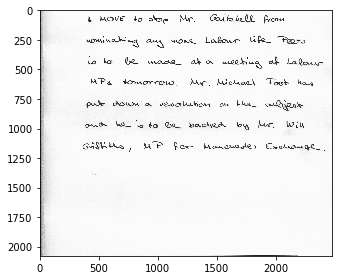

In [ ]:
image = cv2.imread("pic2.png")
io.imshow(image)
plt.show()

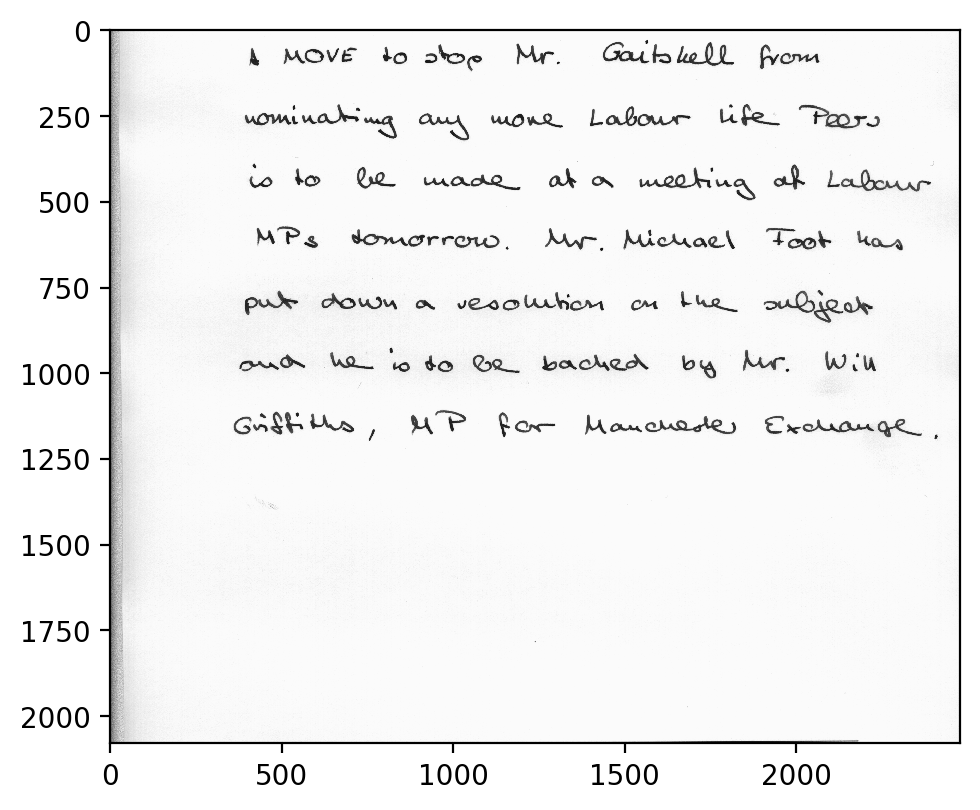

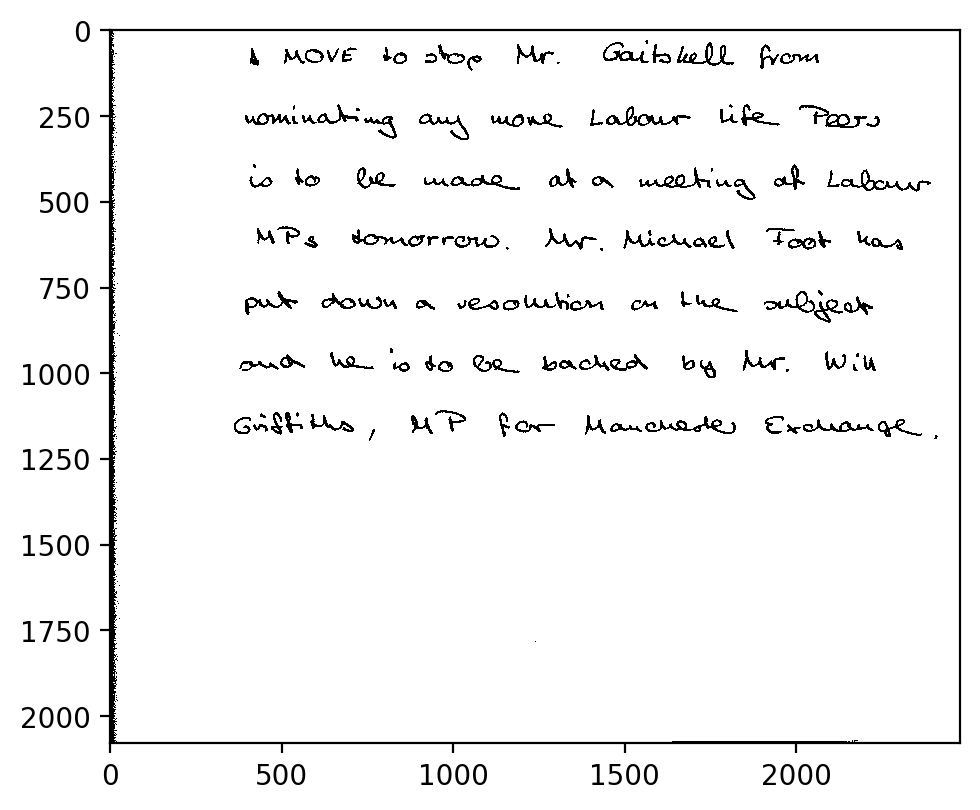

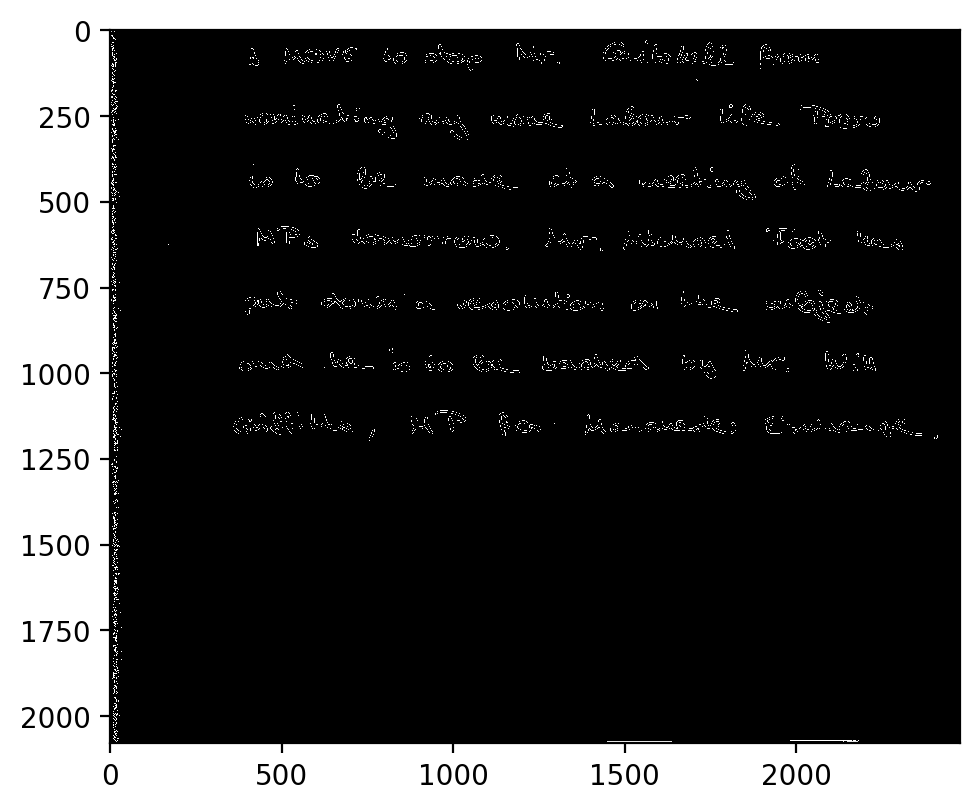

In [ ]:
from skimage import color
from skimage.feature import canny
from skimage.filters import threshold_otsu
image_gray = color.rgb2gray(image)
threshold_value = threshold_otsu(image_gray)
image_gray2 = image_gray > threshold_value
image_edges = canny(image_gray2)

w = 5
h = 5
d = 200
plt.figure(figsize=(w, h), dpi=d)

io.imshow(image_gray)

w = 5
h = 5
d = 200
plt.figure(figsize=(w, h), dpi=d)
io.imshow(image_gray2)
plt.show()

w = 5
h = 5
d = 200
plt.figure(figsize=(w, h), dpi=d)
io.imshow(image_edges)
plt.show()

number of rows:  247
(array([  0,   1,  52,  55,  57,  59,  99, 101, 103, 146, 148, 152, 158,
       200, 241, 243, 245, 247, 297, 299, 302, 357, 365], dtype=int64),)
Line boundaries: [  1  59 103 158 200 247 302 365]
Average height of lines: 52.0
word boundaries  [   0    1    2    4  436  670  674 1842 1846 1848 1852 1856 2060 2467]
shape (2479, 56)
average of no pen lifiting:  189.76923076923077
word boundaries  [   0    1    2   20   24  161  180  225  347  425  435  568  570  668
  760  762  764  767  806  898 1055 1108 1221 1330 1332 1409]
shape (2479, 42)
average of no pen lifiting:  56.36
word boundaries  [   0    1    2 2477]
shape (2479, 53)
average of no pen lifiting:  825.6666666666666
word boundaries  [   0    1    2   20   24   27   33   59   74   80  105  111  142  144
  150  168  170  365  401  538  568  570  590  625  672  721  736  815
  863  907  911  954  982  996 1022 1037 1049 1055 1098 1125 1132 1141
 1148 1170 1176 1208 1247 1251 1296]
shape (2479, 40)
average o

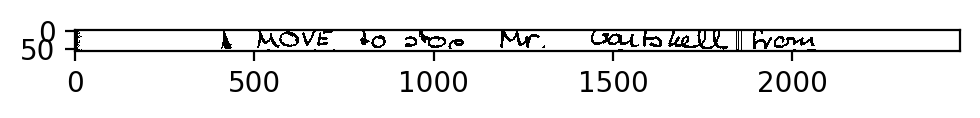

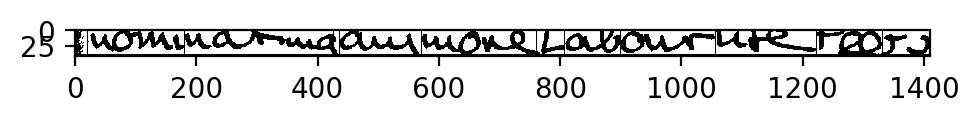

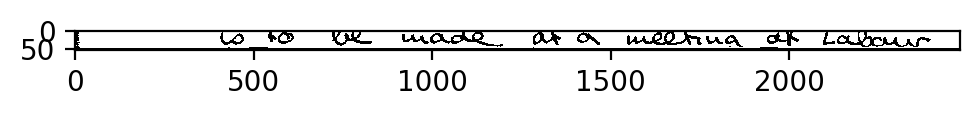

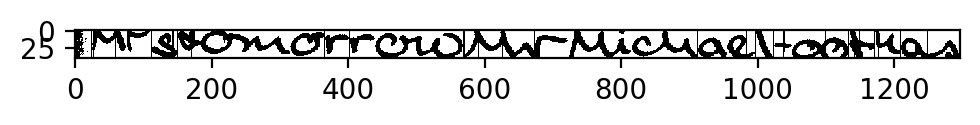

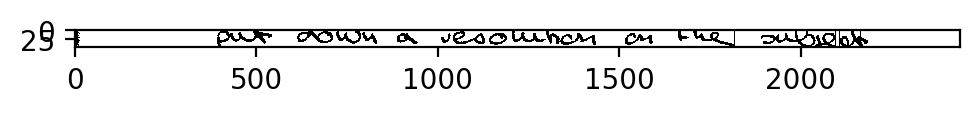

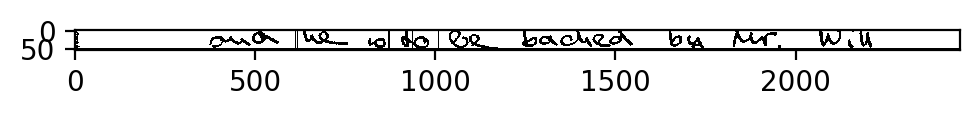

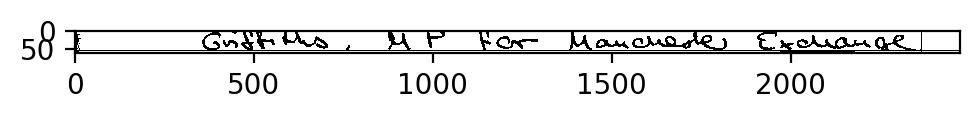

In [ ]:
image_rows_sum = np.sum(image_edges, axis=1)
# print(image_rows[image_rows_sum>threshold_otsu(image_rows_sum)])
# print(threshold_otsu(image_rows_sum))

# w = 5
# h = 5
# d = 200
# plt.figure(figsize=(w, h), dpi=d)
number_of_rows = np.sum(image_rows_sum>threshold_otsu(image_rows_sum))
print("number of rows: ", number_of_rows)
images_lines = image_edges[image_rows_sum>threshold_otsu(image_rows_sum)][:]
image_lines = np.zeros((len(image_edges[0]),))
image_lines.shape
prev_line = 1
for i in range(len(image_gray2)):
    # if image_rows_sum[i] > threshold_otsu(image_rows_sum):
    if image_rows_sum[i] > 40:
        prev_line=1
        image_lines = np.vstack([image_lines,image_gray2[i][:]])
    else:
        if prev_line==1:
            image_lines = np.vstack([image_lines,np.zeros((len(image_edges[0],)))])
        prev_line = 0

boundaries = np.array(np.where(np.sum(image_lines,axis=1) == 0))
boundaries = boundaries.reshape((len(boundaries[0]),))
iteration_range =  range(len(boundaries)-1)
i=0
while i <= len(boundaries)-2:
    if (boundaries[i+1] - boundaries[i]) < 30:
        boundaries = np.delete(boundaries,i)
        i=i-1
    i = i+1

print(np.where(np.sum(image_lines,axis=1) == 0))
print("Line boundaries:",boundaries)
#print(image_lines.shape)

heights = np.zeros((len(boundaries)-1,))
for i in range(len(boundaries)-1):
    heights[i] = boundaries[i+1]-boundaries[i]

print("Average height of lines:", np.sum(heights)/len(heights))


j = 0
while j < len(boundaries) - 1:
    
    one_line_edges = np.transpose(canny(image_lines[boundaries[j]+1: boundaries[j+1]-1][:]))
    one_line = np.transpose(image_lines[boundaries[j]+1:boundaries[j+1]-1][:])
    
    sum_one_line_pixels = np.sum(one_line_edges,axis=1)
    #print(sum_one_line_pixels)
    line_words = np.zeros((len(one_line_edges[0]),))

    prev_word = 1
    for i in range(len(one_line)):
        # if sum_one_line_pixels[i] > threshold_otsu(sum_one_line_pixels):
        if sum_one_line_pixels[i] > 1:
            prev_word=1
            line_words = np.vstack([line_words,one_line[i][:]])
        else:
            if prev_word==1:
                line_words = np.vstack([line_words,np.zeros((len(one_line_edges[0],)))])
            prev_word = 0

    word_boundaries = np.array(np.where(np.sum(line_words,axis=1) == 0))
    word_boundaries = word_boundaries.reshape((len(word_boundaries[0]),))
    print("word boundaries ",word_boundaries)
    # iteration_range =  range(len(word_boundaries)-1)
    # i=0
    # while i <= len(word_boundaries)-2:
    #     if (word_boundaries[i+1] - word_boundaries[i]) < 50:
    #         word_boundaries = np.delete(word_boundaries,i)
    #         i=i-1
    #     i = i+1
    print("shape",one_line.shape)
    line_words = np.transpose(line_words)

    w = 5
    h = 5
    d = 200
    plt.figure(figsize=(w, h), dpi=d)
    io.imshow(line_words)

    number_of_pixels_with_no_pen_lifting = np.zeros((len(word_boundaries)-1,))
    for i in range(len(word_boundaries)-1):
        number_of_pixels_with_no_pen_lifting[i] = word_boundaries[i+1]-word_boundaries[i]

    print("average of no pen lifiting: ",np.sum(number_of_pixels_with_no_pen_lifting)/len(number_of_pixels_with_no_pen_lifting))
    j += 1

# image_edges_2 = canny(image_lines)
# w = 5
# h = 5
# d = 200
# plt.figure(figsize=(w, h), dpi=d)
# io.imshow(image_edges_2)

# w = 5
# h = 5
# d = 200
# plt.figure(figsize=(w, h), dpi=d)
# io.imshow(image_lines)
# plt.show()
# number_of_black_lines = np.sum(np.sum(image_lines,axis=1)==0)
# print(number_of_black_lines)


In [ ]:
def newPipelineTest(imgpath):
  img = cv2.imread(imgpath,cv2.IMREAD_GRAYSCALE)
  
  features = np.full((1, 3), -1)

  ##Step 1 preprocessing
  gs, y = preProcessTheImage(img)
  #plt.imshow(gs)

  #step 2 get CC
  _,stats,_ =getConnectedComponents(y) #get the connected components


  ##step 3 Get average width and height for connected components 
  width = stats[:, 2]
  width_avg = np.average(width[1:]) ##Feature  1
  features[0][0] = width_avg
  #print(width_avg)
  height = stats[:, 3]
  height_avg = np.average(height[1:]) ##Feature 2
  features [0][1] = height_avg
  #print(height_avg)
  #########################

  ##step 4 get angle

  x_cc = stats[1:, 0]
  y_cc = stats[1:, 1]
  width_cc = stats[1:, 2]
  height_cc = stats[1:, 3]
  acc = 0
  vert = 0
  counter_norm = 0
  counter_vert = 0
  for i in range(1, stats.shape[0]):
    x_cc = stats[i][0]
    y_cc = stats[i][1]
    width_cc =stats[i][2]
    height_cc = stats[i][3]

    #stats[0][4]
    #print(x_cc, y_cc, width_cc, height_cc)
    #shadow_img = np.full((height_cc, width_cc), 255)

    shadow_img = gs[y_cc: y_cc + height_cc, x_cc : x_cc + width_cc]
    #shadow_img = gs[0: 500, 0:500]#[0 : 500]
    #plt.imshow(shadow_img)
    rows,cols = shadow_img.shape[:2]
    ret,thresh = cv2.threshold(shadow_img,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]

    [vx,vy,x,y] = cv2.fitLine(cnt, cv2.DIST_L2,0,0.01,0.01)
    lefty = int((-x*vy/vx) + y) #feature 3
    righty = int(((cols-x)*vy/vx)+y)  #feature 3
    #print((-righty+lefty)/cols)
    ang = (-righty+lefty)/cols
    if (ang <= 20):
      acc += ang
      #counter_norm += 1
    else:
      acc += 20
      #counter_vert += 1
    if(ang > 0.05):
      counter_norm += 1  
    #shadow_img = cv2.line(shadow_img,(cols-1,righty),(0,lefty),(0,0,0),2)
    '''
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    shadow_img = cv2.drawContours(shadow_img,[box],0,(0,0,0),2)
    '''
    #plt.figure()
    #plt.imshow(shadow_img)
    ########################
    #print(stats)
    #print(width)
    #plt.imshow(cc_output)
  avg = acc / counter_norm#stats.shape[0]
  #print(avg)  
  features[0][2] = avg
  return features

In [ ]:
def getAvgHeightWidthAngle(gs, y, stats, inpangle=24): ###AA
  features = np.full((1, 3), -1)

  ##step 1 Get average width and height for connected components 
  width = stats[:, 2]
  width_avg = np.average(width[1:]) ##Feature  1
  features[0][0] = width_avg
  height = stats[:, 3]
  height_avg = np.average(height[1:]) ##Feature 2
  features [0][1] = height_avg
  #########################

  ##step 2 get angle
  x_cc = stats[1:, 0]
  y_cc = stats[1:, 1]
  width_cc = stats[1:, 2]
  height_cc = stats[1:, 3]
  acc = 0
  vert = 0
  counter_norm = 0
  counter_vert = 0
  for i in range(1, stats.shape[0]):
    x_cc = stats[i][0]
    y_cc = stats[i][1]
    width_cc =stats[i][2]
    height_cc = stats[i][3]

    shadow_img = gs[y_cc: y_cc + height_cc, x_cc : x_cc + width_cc]
    rows,cols = shadow_img.shape[:2]
    ret,thresh = cv2.threshold(shadow_img,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]

    [vx,vy,x,y] = cv2.fitLine(cnt, cv2.DIST_L2,0,0.01,0.01)
    lefty = int((-x*vy/vx) + y) #feature 3
    righty = int(((cols-x)*vy/vx)+y)  #feature 3
    #print((-righty+lefty)/cols)
    ang = (-righty+lefty)/cols
    if (  abs(ang) <= inpangle):
      acc +=  ang#0
      #counter_norm += 1
    else:
      acc += inpangle * np.sign(ang)
      #counter_vert += 1
    if(ang > 0.05):
      counter_norm += 1  
    
  avg = acc / counter_norm#stats.shape[0]
  #print(avg)  
  features[0][2] = avg
  return features

In [ ]:
def shadowPipeline(imgpath):
  img = cv2.imread(imgpath,cv2.IMREAD_GRAYSCALE)
  gs, y = preProcessTheImage(img)
  _,stats,_ =getConnectedComponents(y) #get the connected components
  return getAvgHeightWidthAngle(gs = gs, y = y, stats= stats)

In [ ]:
def shadowTrainAndPredict(dataset, C = 5.0):
  
  classifier = SVC(C=C, gamma='auto', probability=True)
  imagesList,imagesLabels,pickedTestImage,answer=pickTrainAndTest(dataset)
  #numberOfBlocks=divide*divide
  allFeatures = np.zeros((6,3),dtype=float)
  allLabels = np.zeros(6,dtype=int)

  for i in range(len(imagesList)):
    features = shadowPipeline(getFullPathOfTheImage(imagesList[i]))
    allFeatures[i]=features
    #allLabels[i]= imagesLabels[i]
  
  '''
  maxColWise=np.max(allFeatures,axis=0)
  allFeatures/=maxColWise #normalize the features column wise by dividing by the max of each col
  '''
  classifier.fit(allFeatures, imagesLabels)
  
  testFeatures=shadowPipeline(getFullPathOfTheImage(pickedTestImage))
  #testFeatures/=maxColWise
  isThisACorrectPrediction= (classifier.predict(testFeatures) == answer).astype(int)

  return isThisACorrectPrediction

In [ ]:
def getAccuracyLBPPredictions(imagesList,imagesLabels,pickedTestImage,C=5.0,radius=3,divide=3):
  classifier = SVC(C=C, gamma='auto', probability=True)
  numberOfBlocks=divide*divide
  allFeatures = np.zeros((numberOfBlocks*6,256),dtype=float)
  allLabels = np.zeros(numberOfBlocks*6,dtype=int)

  for i in range(len(imagesList)):
    features,labels=wholePipeline(getFullPathOfTheImage(imagesList[i]),imagesLabels[i],radius=radius,divide=divide)
    allFeatures[i*numberOfBlocks:i*numberOfBlocks+numberOfBlocks,:]=features
    allLabels[i*numberOfBlocks:i*numberOfBlocks+numberOfBlocks]=labels
  
  maxColWise=np.max(allFeatures,axis=0)
  allFeatures/=maxColWise #normalize the features column wise by dividing by the max of each col
  classifier.fit(allFeatures, allLabels)
  
  testFeatures,testLabels=wholePipeline(getFullPathOfTheImage(pickedTestImage),0,radius=radius,divide=divide)
  testFeatures/=maxColWise

  return classifier.predict(testFeatures)

In [ ]:
def getAccuracyCCPrediction(imagesList,imagesLabels,pickedTestImage,C=5.0):
  classifier = SVC(C=C, gamma='auto', probability=True)
  #numberOfBlocks=divide*divide
  allFeatures = np.zeros((6,3),dtype=float)
  allLabels = np.zeros(6,dtype=int)

  for i in range(len(imagesList)):
    features = shadowPipeline(getFullPathOfTheImage(imagesList[i]))
    allFeatures[i]=features
    #allLabels[i]= imagesLabels[i]
  
  '''
  maxColWise=np.max(allFeatures,axis=0)
  allFeatures/=maxColWise #normalize the features column wise by dividing by the max of each col
  '''
  classifier.fit(allFeatures, imagesLabels)
  
  testFeatures=shadowPipeline(getFullPathOfTheImage(pickedTestImage))
  #testFeatures/=maxColWise

  return classifier.predict(testFeatures)[0]

In [ ]:
def getAccuracyLBPPusCCPrediction(dataset,C=5.0):
  imagesList,imagesLabels,pickedTestImage,answer=pickTrainAndTest(dataset)
  predictions=np.zeros(13,dtype=np.int);
  predictions[:9]=getAccuracyLBPPredictions(imagesList,imagesLabels,pickedTestImage,C=C)
  CC=getAccuracyCCPrediction(imagesList,imagesLabels,pickedTestImage,C=C)
  predictions[9:]=np.repeat(CC,4)
  
  isThisACorrectPrediction=(np.bincount(predictions).argmax() == answer).astype(int)
  return isThisACorrectPrediction

In [ ]:
def getAccuarcyGeneral(iterations=10,radius=3,divide=3,C=8.0):
  correctGeneral=0
  for i in range(iterations):
    np.random.seed(i+1)
    correctGeneral+=getAccuracyLBPPusCCPrediction(dataset,C=C)
  return (correctGeneral*100/iterations)

In [ ]:
def shadowGetAccuarcy(iterations=10, C= 5.0):
  correct=0
  for i in range(iterations):
    np.random.seed(i+1)
    correct+=shadowTrainAndPredict(dataset)
  return (correct*100/iterations) #The accuracy

In [ ]:
getAccuarcyGeneral(iterations=1000)

98.0

In [ ]:
#try out different Cs for SVM from range 1->10 and step 1 (New features)
for c in np.arange(1,11,1):
  print("The Accuracy is: ",shadowGetAccuarcy(iterations=100,C=c),", when C is: ",c)

The Accuracy is:  [72.] , when C is:  1
The Accuracy is:  [70.] , when C is:  2
The Accuracy is:  [60.] , when C is:  3
The Accuracy is:  [70.] , when C is:  4
The Accuracy is:  [65.] , when C is:  5
The Accuracy is:  [64.] , when C is:  6
The Accuracy is:  [64.] , when C is:  7
The Accuracy is:  [70.] , when C is:  8
The Accuracy is:  [72.] , when C is:  9
The Accuracy is:  [73.] , when C is:  10


In [ ]:
def potentialTrainAndPredict(dataset, C = 5.0,radius=3,divide=3):
  
  classifier = SVC(C=C, gamma='auto', probability=True)
  imagesList,imagesLabels,pickedTestImage,answer=pickTrainAndTest(dataset)
  numberOfBlocks=divide*divide
  allFeatures = np.zeros((numberOfBlocks*6,259),dtype=float)
  allLabels = np.zeros(numberOfBlocks*6,dtype=int)

  for i in range(len(imagesList)):
    features = shadowPipeline(getFullPathOfTheImage(imagesList[i]))
    features2,labels= wholePipeline(getFullPathOfTheImage(imagesList[i]),imagesLabels[i],radius=radius,divide=divide)
    # print(features2.shape,np.repeat(features,9,axis=0).shape)
    featuresMerged=np.hstack((features2,np.repeat(features,9,axis=0)))
    allFeatures[i*numberOfBlocks:i*numberOfBlocks+numberOfBlocks,:]=featuresMerged
    allLabels[i*numberOfBlocks:i*numberOfBlocks+numberOfBlocks]=labels
  

  maxColWise=np.max(allFeatures,axis=0)
  allFeatures/=maxColWise #normalize the features column wise by dividing by the max of each col
  classifier.fit(allFeatures, allLabels)
  
  testFeatures,testLabels=wholePipeline(getFullPathOfTheImage(pickedTestImage),answer,radius=radius,divide=divide)
  testFeatures2=shadowPipeline(getFullPathOfTheImage(pickedTestImage))
  testFeaturesMerged=np.hstack((testFeatures,np.repeat(testFeatures2,9,axis=0)))
  testFeaturesMerged/=maxColWise
  isThisACorrectPrediction=(np.bincount(classifier.predict(testFeaturesMerged)).argmax() == answer).astype(int)

  return isThisACorrectPrediction

In [ ]:
def potentialGetAccuarcy(iterations=10, C= 5.0):
  correct=0
  for i in range(iterations):
    # np.random.seed(i+1)
    correct+=potentialTrainAndPredict(dataset)
  return (correct*100/iterations) #The accuracy

In [ ]:
potentialGetAccuarcy(iterations=100, C= 5.0)

# Model Selection Previous Trials

In [ ]:
# LET'S TEST SOME MODELS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

KNN = KNeighborsClassifier(n_neighbors=5)
RR = RandomForestClassifier()
GB = GradientBoostingClassifier(learning_rate=0.05,n_estimators=1000,max_depth=32)